## Trading With Python 02 - Simulating leveraged etfs
A while ago I have written a [post](http://matlab-trading.blogspot.nl/2011/05/guess-what-leveraged-etfs-dont-decay.html) about leveraged etfs. While many people think that leveraged etfs decay over time, this is actually not the case. What we see is in fact a non-symmetric distribution, with a high probability of decay, but with the same expected per timestep as the non-leveraged distribution.

To prove this, we can use Monte-Carlo simulation (which is a fancy name for a brute-force approach) to test this hypothesis. 

Before we start, there is one thing that needs a little bit of explanation: *libraries*

###Import modules###
Python has only a limited set of built-in functions. Everyhing else needs to be loaded from optional modules (Don't get confused,  *modules* and *libraries* are the same thing). We will use `%pylab` magic to load most of the  scientific libraries, including plotting functions.

## %pylab inline用于导入大部分科学库，包括画图功能

We will be looking at [modules](http://docs.python.org/2/tutorial/modules.html) later on, for now it is enough just to start the notebook and run the  `%pylab inline` command. `inline` causes the figures to appear inside the notebok instead of a popup window.




In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Create a synthetic price

Suppose we have an etf with normally distributed daily returns. Average daily return is 0 and standard deviation is 1%. In other words chances of going up 1% are equal to chances of going down 1%

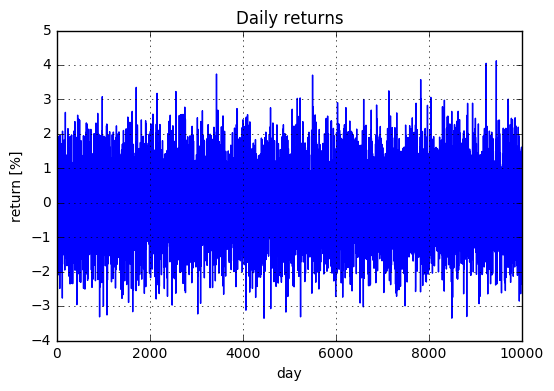

In [2]:
returns = randn(10000) # create a 1000-day returns vector. 
#Note: don't use 'return' as a variable name, this keyword is reserved.
plot(returns) #plot the time series
grid(True) #use grid in the plot

#-------add labels to the chart
title('Daily returns') 
xlabel('day')
ylabel('return [%]')

Let's see how this distribution looks on a histogram and check if `mean`  (average) and `std` (standard deviation) are what we expect
Note: for printing *std* I am using here string formatting in the form of `%.2f`, which means that a floating number is printed with two decimals precision.

Mean: 0.00188133861886
Standard deviation:1.00


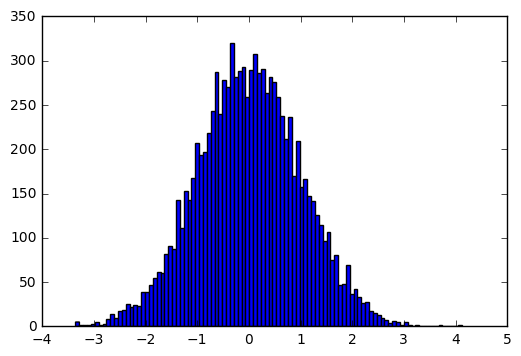

In [3]:
h = hist(returns,100) # make a histogram of returns, using 100 bins. 
#h is used as a return variable to avoid text output

print('Mean:' , returns.mean()) # print mean 
print('Standard deviation:%.2f' % returns.std()) # print sigma, note the 2 decimal precision notation

Suppose we would start on day 0 with an investment of `$100`. On day n our investment would then have a value of `100*r[t]*r[t+1]*...r[n]`, which is achieved by the cumulative product function. Don't forget to divide % returns by 100 and add 1 to the daily returns as we are multiplying by 1.05 in case of 5% return

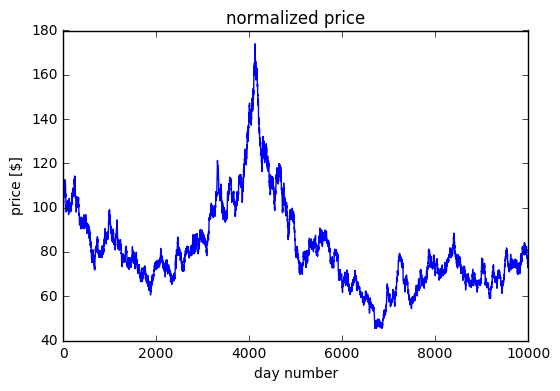

In [4]:
price = 100*(returns/100+1).cumprod() # normalized price
plot(price) # plot cumulative sum of returns
title('normalized price') # set plot title
xlabel('day number') # add x label to the chart
ylabel('price [$]') # add y label


You will notice that each time you run the code in the previous cells, the result is different. This is of course because we used the random number generator.
Now we can do the same calculation, but for many simulated prices at once. We could use a loop for this and repeat the above calculation many times, but there is a more elegant way. (note: the `returns` variable from previous calculations is overwritten with a matrix)

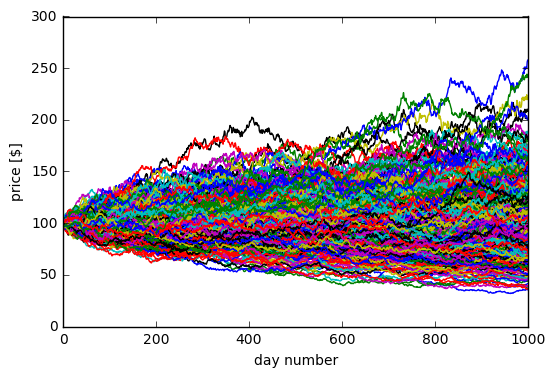

In [5]:
returns = randn(1000,5000) # generate 1000x5000 random return series
prices = 100*(returns/100+1).cumprod(axis=0) # normalized price, you need to specify along which axis 
                                            #(0 is along columns) the cumulative product is calculated.
h = plot(prices[:,:500]) # plot cumulative sum of returns. Because plotting all 5000 prices would take 
                         # a long time, only first 500 are plotted
xlabel('day number')
ylabel('price [$]')

The final price (on the 1000th day) of the `prices` matrix (or table if you like spreadsheet terminology) is just the last row. Let's plot a histogram of it.

Mean: 99.9348117188
Std: 32.6382826921


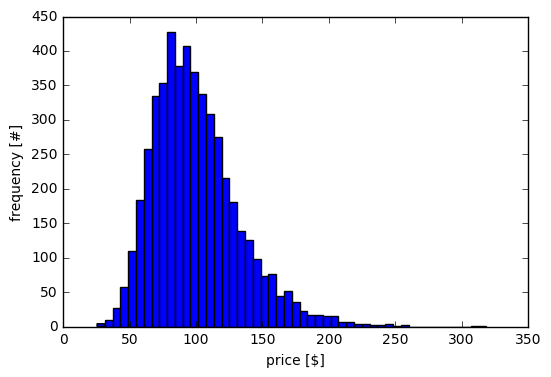

In [6]:
finalPrice = prices[-1,:] # get the last row of prices table
h = hist(finalPrice,50) # plot histogram with 50 bins
xlabel('price [$]') # add axis labels
ylabel('frequency [#]')

print('Mean:', finalPrice.mean()) # show mean value
print('Std:', finalPrice.std()) # show standard deviation

The mean of resulting distribution is very close to our starting value of `100$`, but the distribution is now skewed to the right. Calculating standard deviation for this distribution can be misleading, because it is not a normal distribution any more.


**conclusion** : an equal chance of going up or down in % does not change long term expected value. The resulting distribution is however skewed, therefore we see a price decline more often, but it is compensated by the fat tails on the up side. 

## How about 3x leverage?
 
Let's calculate and plot a 3x leveraged result.
We can reuse the return matrix from previous calculation

Mean 3x: 100.239278587


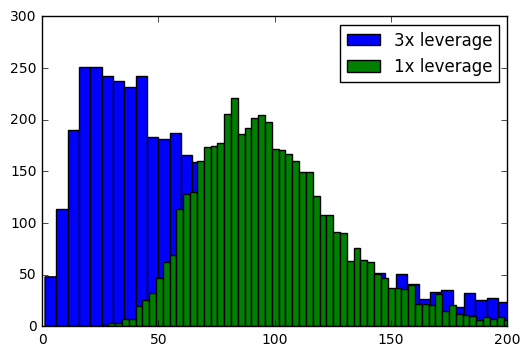

In [7]:
returns3x = returns*3. # leveraged returns are 3x the non-leveraged returns
prices3x = 100*(returns3x/100+1).cumprod(axis=0) # normalized price, you need to specify along which axis 

finalPrice3x = prices3x[-1,:] # get the last row of prices table行用一个数字调用，这样产生的是一维数组，如果 [-1:,:]调用就是二维，不能hist画图.

h1 = hist(finalPrice3x,500) # plot histogram with 500 bins. more bins are needed to keep the bin width small.
h2 = hist(finalPrice,100) # plot histogram with 100 bins
xlim([0,200]) # set x axis limits to 0..200 设置限制
legend(['3x leverage','1x leverage'])

print('Mean 3x:', finalPrice3x.mean())


That is funny: while the 3x leveraged etf most of the time finishes under the `$50` mark, the fat tail on the right keeps the long term average at `$100`
The tail on the right is in fact so large, that I had to limit the x-axis.


### Conclusion ###
Long term expected value does not change with increasing etf leverage, but the *likelyhood* of ending up with a loss *increases*.


### Excersize ###
The above calculation is done for an etf that has no alpha bias (average daily return is 0%). Most of the stocks however do have a positive bias. 
Investigate what would happen with if an etf would be based on a normal distribution with an average daily return being 0.001%